# Customer Segmentation using Ensemble Learning

## 📌 Project Overview
This project analyzes customer data from a mall to understand spending behavior, income patterns, and demographics.  
We apply **clustering (KMeans)** to generate pseudo-labels, perform **EDA and visualizations**, and then use **ensemble learning techniques** including:

- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost

In [27]:
#Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [28]:
#Load Dataset
df = pd.read_csv("Mall_Customers.csv")
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [10]:
#EDA
print("Dataset Info:")
print(df.info())
print("\n Missing Values:\n", df.isnull().sum())
print("\n Summary Statistics:\n", df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

 Missing Values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

 Summary Statistics:
        CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264

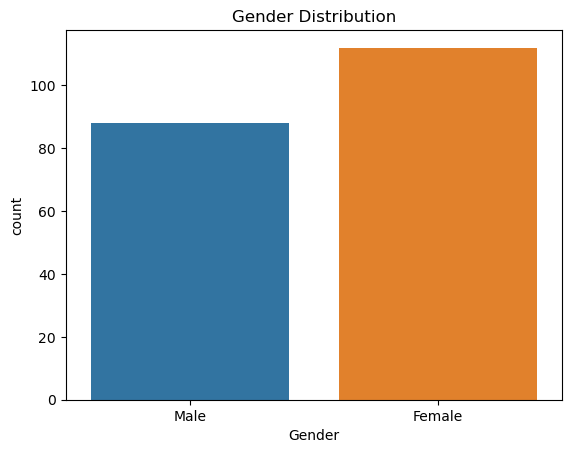

In [12]:
#Gender Distribution
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.show()

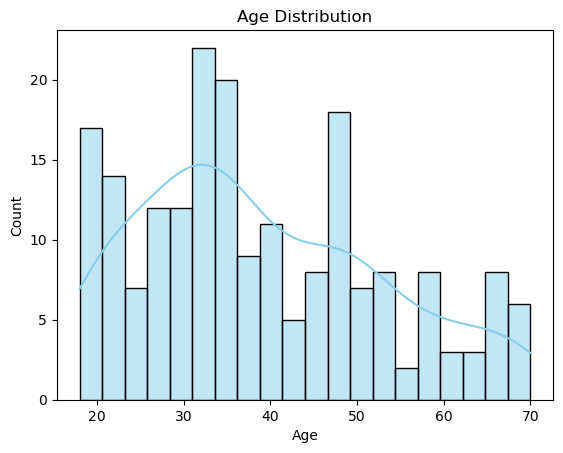

In [14]:
#Age Distribution
sns.histplot(df['Age'], kde=True, bins=20, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

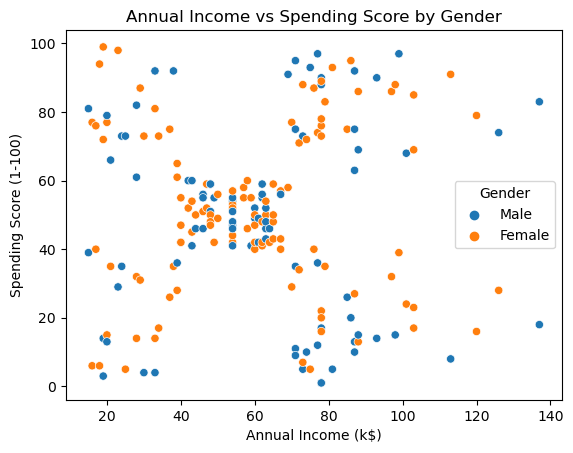

In [15]:
#Spending Score vs Income Scatter Plot
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', data=df)
plt.title("Annual Income vs Spending Score by Gender")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

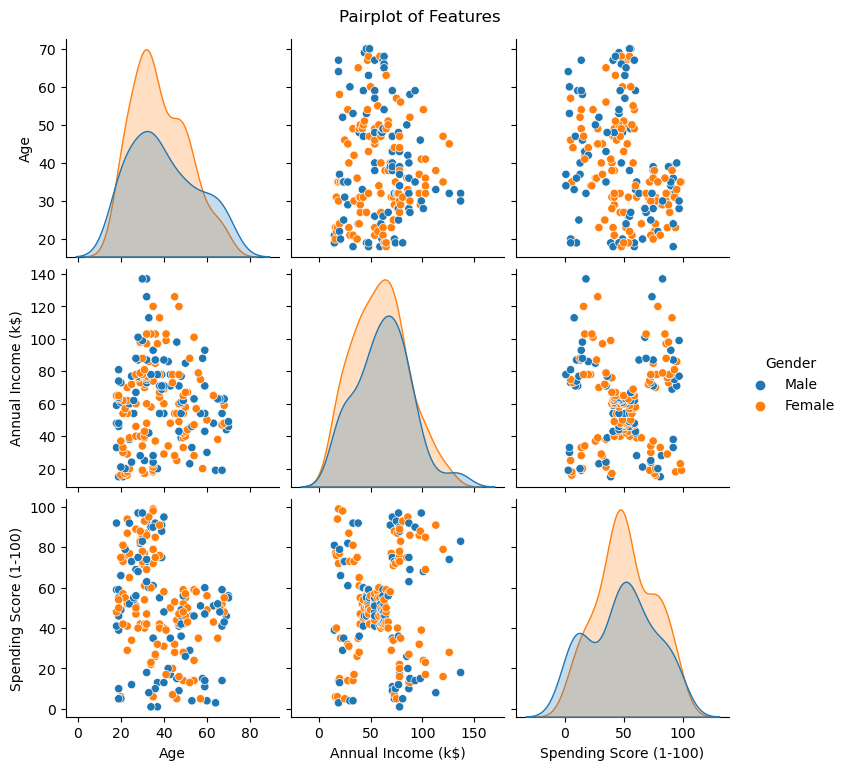

In [16]:
#Pairplot of Features
sns.pairplot(df.drop('CustomerID', axis=1), hue="Gender")
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

In [17]:
#Data Preprocessing
df_model = df.drop("CustomerID", axis=1)
df_model["Gender"] = LabelEncoder().fit_transform(df_model["Gender"])

In [18]:
#Standardize Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model)

In [29]:
#KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_model["Cluster"] = kmeans.fit_predict(scaled_features)

In [30]:
X = df_model.drop("Cluster", axis=1)
y = df_model["Cluster"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
#Initialize Models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [32]:
#Cross-Validation Scores
from sklearn.model_selection import cross_val_score

print(" Cross-Validation Scores (Accuracy - 5 folds):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)
    print(f"{name}: Mean Accuracy = {scores.mean():.2f}")

 Cross-Validation Scores (Accuracy - 5 folds):
Decision Tree: Mean Accuracy = 0.94
Random Forest: Mean Accuracy = 0.98
Gradient Boosting: Mean Accuracy = 0.94
XGBoost: Mean Accuracy = 0.97


In [33]:
#Hyperparameter Tuning (GridSearchCV for XGBoost)
param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train, y_train)

print(" Best Parameters (XGBoost):", grid_xgb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best Parameters (XGBoost): {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}


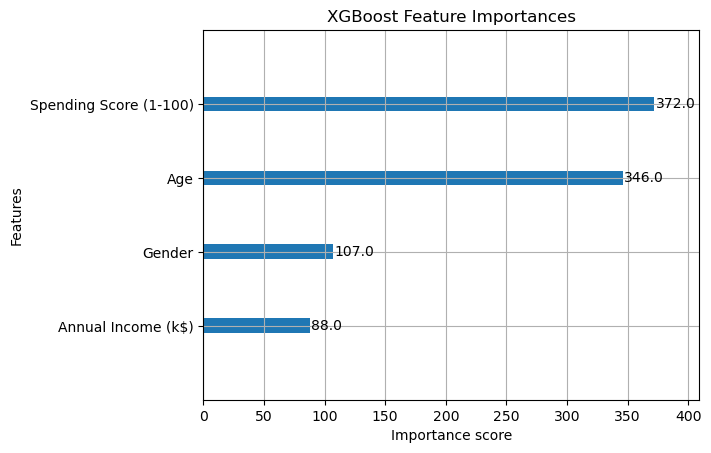

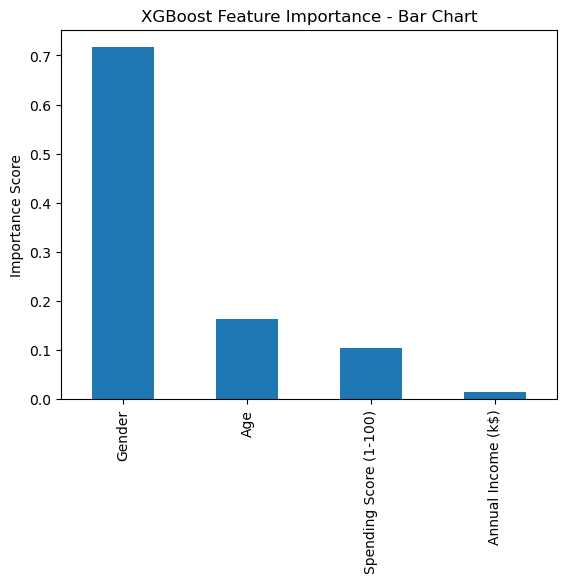

In [34]:
#Feature Importance (XGBoost)
best_xgb = grid_xgb.best_estimator_

# Plot importance
plot_importance(best_xgb)
plt.title("XGBoost Feature Importances")
plt.show()

# Also display raw values
feat_importance = pd.Series(best_xgb.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=False).plot(kind='bar')
plt.title("XGBoost Feature Importance - Bar Chart")
plt.ylabel("Importance Score")
plt.show()

In [36]:
# 🧾 Step 12: Final Evaluation of All Models
print(" Classification Report on Test Set:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n {name}:\n")
    print(classification_report(y_test, y_pred))

 Classification Report on Test Set:


 Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00         8

    accuracy                           0.97        40
   macro avg       0.98      0.98      0.98        40
weighted avg       0.98      0.97      0.97        40


 Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         8

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


 Gradient Boosting:

              precision    recall  

In [37]:
#Train & Evaluate Models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report

In [38]:
#Print Evaluation Results
print("\n Model Evaluation (Macro Avg F1-Score):")
for name in results:
    f1 = results[name]['macro avg']['f1-score']
    print(f"{name}: F1-score = {f1:.2f}")


 Model Evaluation (Macro Avg F1-Score):
Decision Tree: F1-score = 0.98
Random Forest: F1-score = 1.00
Gradient Boosting: F1-score = 1.00
XGBoost: F1-score = 1.00
